### Data Transformation

#### Data Transformation Wrangle function

In [96]:
import pandas as pd
import re
import sqlite3

In [97]:
def wrangle_data(df):
    df = df.copy()

    # ORDER_ID
    df = df.reset_index(drop=True)
    df['order_id'] = df.index + 1

    # CUSTOMER_NAME
    df['customer_name'] = (
        df['customer_name']
        .astype(str)
        .str.strip()
        .str.title()
        .replace('Nan', pd.NA)
    )
    df['customer_name'] = df['customer_name'].fillna('Unknown')
    df['customer_name'] = df['customer_name'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # PRODUCT
    df['product'] = (
        df['product']
        .astype(str)
        .str.strip()
        .str.title()
        .apply(lambda x: re.sub(r'\s+', ' ', x))
    )
    mode_by_price = (
        df[df['product'] != 'Nan']
        .groupby('unit_price')['product']
        .agg(lambda x: x.mode().iloc[0])
    )
    df['product'] = df.apply(
        lambda row: mode_by_price.get(row['unit_price'], row['product'])
                    if pd.isna(row['product']) else row['product'],
        axis=1
    )

    # QUANTITY
    df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce').abs()
    df['quantity'] = df['quantity'].fillna(
        df.groupby('product')['quantity'].transform('median')
    )
    df['quantity'] = df['quantity'].fillna(
        df.groupby('customer_name')['quantity'].transform('median')
    )
    df['quantity'] = df['quantity'].fillna(df['quantity'].median())

    # UNIT_PRICE
    df['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')

    def impute_unit_price(grp):
        mode = grp.mode()
        if not mode.empty:
            return grp.fillna(mode.iloc[0])
        else:
            return grp.fillna(grp.ffill())

    df['unit_price'] = df.groupby(['region', 'product'])['unit_price'].transform(impute_unit_price)
    df['unit_price'] = df.groupby('product')['unit_price'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.ffill()))

    # ORDER_DATE
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    df['order_date'] = df['order_date'].ffill()

    # REGION
    df['region'] = (
        df['region']
        .astype(str)
        .str.strip()
        .str.title()
        .replace('Nan', pd.NA)
    )
    most_common = df['region'].mode().iloc[0]
    df['region'] = df['region'].fillna(most_common)

    # SORT BY ORDER_DATE
    df = df.sort_values('order_date').reset_index(drop=True)

    # TOTAL_PRICE
    df['total_price'] = df['quantity'] * df['unit_price']

    # PRICE_TIER
    bins = [0, 500, 1000, 2000, float('inf')]
    labels = ['Low', 'Medium', 'High', 'Premium']
    df['price_tier'] = pd.cut(df['total_price'], bins=bins, labels=labels)

    return df


In [98]:
# Apply wrangling
df_full = pd.read_csv("data/raw_data.csv")
df_incremental = pd.read_csv("data/incremental_data.csv")

df_full_cleaned = wrangle_data(df_full)
df_incremental_cleaned = wrangle_data(df_incremental).dropna()


In [99]:
df_full_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       100 non-null    int64         
 1   customer_name  100 non-null    object        
 2   product        100 non-null    object        
 3   quantity       100 non-null    float64       
 4   unit_price     100 non-null    float64       
 5   order_date     100 non-null    datetime64[ns]
 6   region         100 non-null    object        
 7   total_price    100 non-null    float64       
 8   price_tier     100 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 6.7+ KB


In [100]:
df_incremental_cleaned .info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 9
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       9 non-null      int64         
 1   customer_name  9 non-null      object        
 2   product        9 non-null      object        
 3   quantity       9 non-null      float64       
 4   unit_price     9 non-null      float64       
 5   order_date     9 non-null      datetime64[ns]
 6   region         9 non-null      object        
 7   total_price    9 non-null      float64       
 8   price_tier     9 non-null      category      
dtypes: category(1), datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 861.0+ bytes


In [91]:
df_incremental_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 9
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       9 non-null      int64         
 1   customer_name  9 non-null      object        
 2   product        9 non-null      object        
 3   quantity       9 non-null      float64       
 4   unit_price     9 non-null      float64       
 5   order_date     9 non-null      datetime64[ns]
 6   region         9 non-null      object        
 7   total_price    9 non-null      float64       
 8   price_tier     9 non-null      category      
dtypes: category(1), datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 861.0+ bytes


## Exploration

#### Order_id

In [ ]:
def check_order_id(df_full):
    result = {
        "total_rows": len(df),
        "missing_order_id": df['order_id'].isnull().sum(),
        "duplicate_order_id": df['order_id'].duplicated().sum(),
        "dtype": df['order_id'].dtype,
        "n_unique": df['order_id'].nunique(),
        "is_monotonic_increasing": df['order_id'].is_monotonic_increasing
    }
    return result


In [ ]:
check_order_id(df_full)

{'total_rows': 100,
 'missing_order_id': 0,
 'duplicate_order_id': 1,
 'dtype': dtype('int64'),
 'n_unique': 99,
 'is_monotonic_increasing': False}

In [21]:
# Find duplicated order_id values
duplicate_ids = df_full[df_full['order_id'].duplicated(keep=False)]

# Show the rows with those duplicate IDs
print(duplicate_ids.sort_values('order_id'))


   order_id customer_name product  quantity  unit_price  order_date region
3         4           Eve  Laptop       2.0       750.0  2024-01-07   West
5         4           Eve  Laptop       2.0       750.0  2024-01-07   West


In [22]:
# --- ORDER_ID ---
df_full= df_full.reset_index(drop=True)
df_full['order_id'] = df_full.index + 1  # Reassign to strict sequence

#### customer_name
Checks for customer_name

    Missing values
    → Identify and decide whether to impute (e.g., "Unknown") or drop.

    Whitespace / Formatting issues
    → Remove leading/trailing spaces; standardize case.

    Inconsistent casing
    → Example: john doe, JOHN DOE, John Doe → all should be John Doe.

    Unexpected entries / typos
    → Optional: flag extremely short names (len(name) < 2) or numeric entries.

    Duplicates (optional)
    → If two names are slightly different but clearly same customer (e.g., Jon Smith, John Smith), flag for review.

In [47]:
# Missing values
print("Missing:", df_full['customer_name'].isnull().sum())

# Unique names
print("Unique:", df_full['customer_name'].nunique())

# Example values
print(df_full['customer_name'].unique()[:10])

# Suspiciously short or numeric-only names
df_full[df_full['customer_name'].str.strip().str.len() < 2]


Missing: 1
Unique: 6
['Diana' 'Eve' 'Charlie' nan 'Frank' 'Bob' 'Alice']


,order_id,customer_name,product,quantity,unit_price,order_date,region


In [ ]:
# Ensure order_date is datetime
df_full['order_date'] = pd.to_datetime(df_full['order_date'], errors='coerce')

# Sort by order_date ascending
df_full_sorted = df_full.sort_values('order_date')
df_full_sorted.missing_rows = df_full_sorted[df_full_sorted['customer_name'].isnull()]

C:\Users\Admin\AppData\Local\Temp\ipykernel_12236\2425363892.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_full_sorted.missing_rows = df_full_sorted[df_full_sorted['customer_name'].isnull()]


,order_id,customer_name,product,quantity,unit_price,order_date,region
3,4,Eve,Laptop,2.0,750.0,2024-01-07,West
5,4,Eve,Laptop,2.0,750.0,2024-01-07,West
90,91,Bob,Phone,2.0,NaN,2024-01-09,West
40,41,Alice,Monitor,1.0,250.0,2024-01-17,West
67,68,Diana,Monitor,1.0,NaN,2024-01-18,West
35,36,Frank,Phone,3.0,750.0,2024-01-19,West
25,26,Eve,Monitor,3.0,750.0,2024-01-21,West
76,77,Bob,Tablet,NaN,750.0,2024-01-24,West
98,99,Alice,Monitor,NaN,250.0,2024-01-26,West
22,23,Diana,Tablet,3.0,500.0,2024-01-27,West


In [54]:
# Assuming df_full_sorted is already your cleaned, sorted DataFrame
result = df_full_sorted[
    (df_full_sorted['region'] == 'West') &
    (df_full_sorted['product'] == 'Monitor') &
    (df_full_sorted['quantity'] == 3)
]

print(result)


    order_id customer_name  product  quantity  unit_price order_date region
25        26           Eve  Monitor       3.0       750.0 2024-01-21   West
82        83         Diana  Monitor       3.0       250.0 2024-03-06   West
10        11           NaN  Monitor       3.0       750.0 2024-04-24   West


In [51]:
# Ensure order_date is datetime
df_full['order_date'] = pd.to_datetime(df_full['order_date'], errors='coerce')

# Sort by order_date ascending
df_full_sorted = df_full.sort_values('order_date')
df_full_sorted.missing_rows = df_full_sorted[df_full_sorted['customer_name'].isnull()]
print("Missing row(s):")
print(missing_rows)

Missing row(s):
    order_id customer_name  product  quantity  unit_price  order_date region
10        11           NaN  Monitor       3.0       750.0  2024-04-24   West


C:\Users\Admin\AppData\Local\Temp\ipykernel_12236\2337048187.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_full_sorted.missing_rows = df_full_sorted[df_full_sorted['customer_name'].isnull()]


In [26]:
# Data cleaning
df_full['customer_name'] = df_full['customer_name'].str.strip().str.title()
df_full['customer_name'] = df_full['customer_name'].fillna('Unknown')


In [31]:
# Missing values
print("Missing:", df_full['customer_name'].isnull().sum())

# Unique names
print("Unique:", df_full['customer_name'].nunique())

df_full[df_full['customer_name'].astype(str).str.match(r'^\s') | df['customer_name'].astype(str).str.match(r'.*\s$')]

# Example values
print(df_full['customer_name'].unique()[:10])

# Suspiciously short or numeric-only names
df_full[df_full['customer_name'].str.strip().str.len() < 2]


Missing: 0
Unique: 7
['Diana' 'Eve' 'Charlie' 'Unknown' 'Frank' 'Bob' 'Alice']


,order_id,customer_name,product,quantity,unit_price,order_date,region


### Product
Checks for product

    Missing values
    → Shouldn’t be missing — decide to drop or impute (e.g., "Unknown Product" or based on unit_price if possible).

    Whitespace / formatting issues
    → Strip spaces, standardize capitalization.

    Casing inconsistencies
    → Example: "pc", "Laptop" → standardize to "Laptop".

    Typos or inconsistencies (optional)
    → Detect near-duplicates (e.g., "Laptop" vs "Lapt0p").

    Duplicate logic
    → Two products with the same name but wildly different unit_price may suggest a mismatch.

In [104]:
# Missing values
print("Missing:", df_full['product'].isnull().sum())

# Unique products
print("Unique:", df_full['product'].nunique())
# For product
mask = df_full['product'] != df_full['product'].str.strip()
print(df_full[mask])
# For product column
df_full[df_full['product'].astype(str).str.match(r'^\s') | df_full['product'].astype(str).str.match(r'.*\s$')]

# Sample values
print(df_full['product'].dropna().unique()[:10])


Missing: 0
Unique: 4
Empty DataFrame
Columns: [order_id, customer_name, product, quantity, unit_price, order_date, region]
Index: []
['Tablet' 'Laptop' 'Monitor' 'Phone']


### Quantity

In [32]:
# Check for missing
print("Missing:", df_full['quantity'].isnull().sum())

# Summary stats
print(df_full['quantity'].describe())

# Negative values
df_full[df_full['quantity'] < 0]

# Data type
print(df_full['quantity'].dtype)


Missing: 26
count    74.000000
mean      1.959459
std       0.818271
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       3.000000
Name: quantity, dtype: float64
float64


In [57]:
# Step 1: Product-level median (most specific)
df_full['quantity'] = df_full['quantity'].fillna(df_full.groupby('product')['quantity'].transform('median'))

# Step 2: Customer-level median (if product was missing)
df_full['quantity'] = df_full['quantity'].fillna(df_full.groupby('customer_name')['quantity'].transform('median'))

# Step 3: Global median (final fallback)
df_full['quantity'] = df_full['quantity'].fillna(df_full['quantity'].median())


### Region

In [58]:
# 1. Print count of missing values in 'region'
print("Missing values in 'region':", df_full['region'].isnull().sum())

# 2. Print value counts (including NaN)
print("\nValue counts for 'region':")
print(df_full['region'].value_counts(dropna=False))

# 3. Check for invalid region values
valid = {'North', 'South', 'East', 'West'}
invalid_regions = set(df_full['region'].dropna().unique()) - valid
print("\nInvalid region values found:", invalid_regions)

# 4. Check for leading/trailing whitespace
mask = df_full['region'].astype(str).str.match(r'^\s') | df_full['region'].astype(str).str.match(r'.*\s$')
print("\nRegions with whitespace issues:")
print(df_full.loc[mask, 'region'].unique())

# 5. (Repeated check for consistency)
mask = df_full['region'].astype(str).str.match(r'^\s') | df_full['region'].astype(str).str.match(r'.*\s$')
print("\nDuplicate whitespace check (should match above):")
print(df_full.loc[mask, 'region'].unique())

Missing values in 'region': 25

Value counts for 'region':
region
South    26
NaN      25
West     25
North    15
East      9
Name: count, dtype: int64

Invalid region values found: set()

Regions with whitespace issues:
[]

Duplicate whitespace check (should match above):
[]


### Unit Price

In [103]:
# 1. Data type
print("Data type of unit_price:", df_full['unit_price'].dtype)


# 2. Count of missing values
print("\nMissing values:", df_full['unit_price'].isnull().sum())

# 3. Count of negative values
print("Negative values:", (df_full['unit_price'] < 0).sum())

# 4. Count of zero values (if any)
print("Zero values:", (df_full['unit_price'] == 0).sum())

# 5. Unique values (optional for small datasets)
print("\nUnique prices:", df_full['unit_price'].dropna().unique())

# 6. Number of unique prices per product
print("\nUnique unit prices per product:")
print(df_full.groupby('product')['unit_price'].nunique())


Data type of unit_price: float64

Missing values: 35
Negative values: 0
Zero values: 0

Unique prices: [500. 250. 750.]

Unique unit prices per product:
product
Laptop     3
Monitor    3
Phone      3
Tablet     3
Name: unit_price, dtype: int64


In [102]:
# Step 1: Analyze region-product price distribution
print("Region-Product Price Analysis:")
for region in df_full["region"].dropna().unique():
    print(f"\nRegion: {region}")
    region_data = df_full[df_full["region"] == region]
    print(region_data.groupby("product")["unit_price"].unique())


Region-Product Price Analysis:

Region: South
product
Laptop                   [nan, 250.0]
Monitor                  [nan, 750.0]
Phone                    [nan, 250.0]
Tablet     [500.0, nan, 250.0, 750.0]
Name: unit_price, dtype: object

Region: North
product
Laptop     [nan, 250.0, 500.0]
Monitor                [500.0]
Phone             [750.0, nan]
Tablet     [nan, 250.0, 750.0]
Name: unit_price, dtype: object

Region: West
product
Laptop            [750.0, nan, 500.0]
Monitor    [750.0, 500.0, 250.0, nan]
Phone             [750.0, 500.0, nan]
Tablet          [750.0, 500.0, 250.0]
Name: unit_price, dtype: object

Region: East
product
Laptop     [250.0, 500.0]
Monitor      [750.0, nan]
Phone               [nan]
Tablet       [750.0, nan]
Name: unit_price, dtype: object


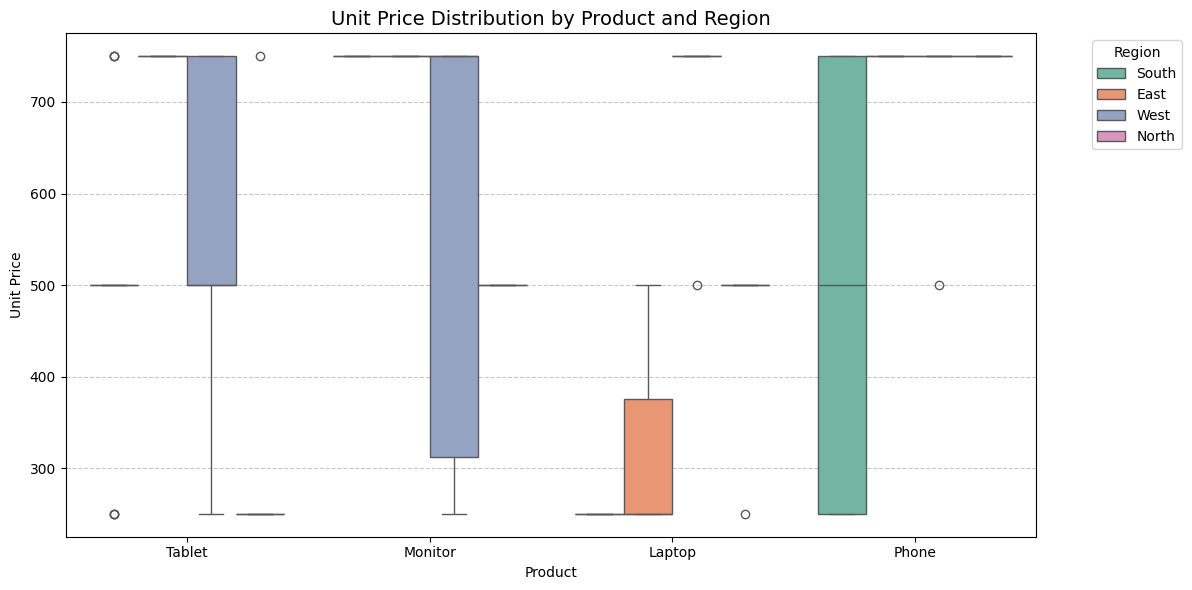

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric unit_price and clean data
df_full['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')
df_full = df.dropna(subset=['unit_price', 'product', 'region'])

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="product", y="unit_price", hue="region", palette="Set2")

plt.title("Unit Price Distribution by Product and Region", fontsize=14)
plt.ylabel("Unit Price")
plt.xlabel("Product")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
